In [1]:
import cv2,os
import math
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict

import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from torch.nn import functional as F

In [2]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image
from torchvision.models import resnet50

def predict(model,input_tensor,true_y):
    model.eval()
    output = model(input_tensor)
    pre_y = output.argmax(1).cpu().item()
    return pre_y==true_y, pre_y

def gradcams(model,input_tensor,target_layers,imgpad,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
    else:
        return print("your option is not support")
    # Note: input_tensor can be a batch tensor with several images!
    # If None, returns the map for the highest scoring category. 
    # Otherwise, targets the requested index. target_index = 1
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets,aug_smooth=True,eigen_smooth=True)
    grayscale_cam = cam(input_tensor, targets)[0]
    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=False)
    
    # Guided-GradCAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, targets)
    if np.amax(gb)!=0:
        gb = np.maximum(gb,0)*(1/np.amax(gb))
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cam_mask * gb
    
    return visualization,grayscale_cam,cam_gb,cam_mask

In [3]:
Ctrl = np.load("./Datasets/Ctrl.npy",allow_pickle=True)
VPA = np.load("./Datasets/VPA.npy",allow_pickle=True)
chip_li = ["All", "H3K27ac", "CTCF", "Hoechst"]
print(Ctrl.shape)
print(VPA.shape)

(4, 100, 600, 600, 3)
(4, 100, 600, 600, 3)


In [4]:
chip="H3K27ac"
resnet="Resnet10_noavg"
optioncam = "ScoreCAM"

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        self.resnet = models.resnet18(weights=True)
        self.resnet.layer3 = nn.Sequential()
        self.resnet.layer4 = nn.Sequential()
        self.resnet.avgpool = nn.Sequential()
        self.resnet.fc = nn.Linear(128*75*75, 2)
    def forward(self, x):
        x = self.resnet(x)
        x = nn.Softmax(dim=1)(x)
        return x
device = "cuda"
model = ResNet().to(device)
model.resnet.load_state_dict(torch.load("./Models/"+resnet+"_"+chip+"/Fold0.pkl"))

/home/acd13264yb/python10_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [6]:
target_layers = [model.resnet.layer2]
def pltcam(img, y, chip):
#     model.resnet.load_state_dict(torch.load("./Models/"+resnet+"_"+chip+"/Fold0.pkl"))
    img = np.float32(img)/255
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,y)
    visualization,cam_one,cam_gb,cam_merge = gradcams(model,input_tensor,target_layers,img,optioncam)
    return cam_one

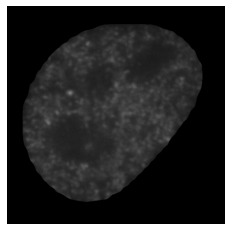

100%|██████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 26.59it/s]


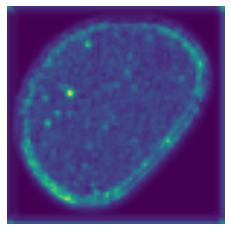

In [53]:
img = VPA[1][11]

plt.axis("off")
plt.imshow(img)
plt.show()

cam_img = pltcam(img,1,chip)
plt.axis("off")
plt.imshow(cam_img)
plt.show()

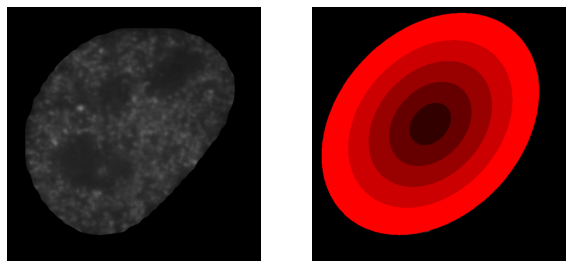

In [52]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0 , 1, cv2.THRESH_BINARY)[1]

contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)
ellipse = cv2.fitEllipse(big_contour)
(xc,yc),(d1,d2),angle = ellipse
result = img.copy()
num_parts = 5
for i in range(num_parts, 0, -1):
    if i == 5:
        cv2.ellipse(result, ((xc,yc),(d1*(i+0.3)/5,d2*(i+0.3)/5),angle), (255*i/num_parts), -1)
    else:
        cv2.ellipse(result, ((xc,yc),(d1*(i)/5,d2*(i)/5),angle), (255*i/num_parts), -1)
# xc, yc = ellipse[0]
# cv2.circle(result, (int(xc),int(yc)), 10, (255, 255, 255), -1)
# rmajor = max(d1,d2)/2
# if angle > 90:
#     angle = angle - 90
# else:
#     angle = angle + 90
# xtop = xc + math.cos(math.radians(angle))*rmajor
# ytop = yc + math.sin(math.radians(angle))*rmajor
# xbot = xc + math.cos(math.radians(angle+180))*rmajor
# ybot = yc + math.sin(math.radians(angle+180))*rmajor
# cv2.line(result, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 0, 255), 3)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(img)
plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(result)

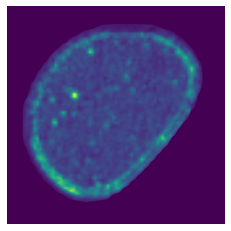

(600, 600)


In [77]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0 , 1, cv2.THRESH_BINARY)[1]
mask = thresh.copy()
h, w = thresh.shape[:2]
scale = 0.9
new_h, new_w = int(h * scale), int(w * scale)
pad = (h - new_h) // 2
resized = cv2.resize(cam_img, (new_w, new_h))
cam_pad = cv2.copyMakeBorder(resized, top=pad, bottom=pad, left=pad, right=pad, borderType=cv2.BORDER_CONSTANT, value=[0,0,0])

cam_pad*=thresh
plt.axis("off")
plt.imshow(cam_pad)
plt.show()
print(cam_pad.shape)

(600, 600)


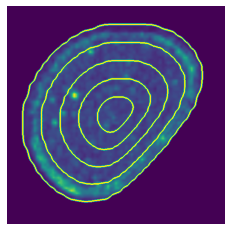

In [90]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0 , 1, cv2.THRESH_BINARY)[1]
print(thresh.shape)
cam_pad_copy = cam_pad.copy()
cam_pad_copy *= 255
h, w = thresh.shape[:2]
contours_li = []
num_parts = 5
for i in range(num_parts, 0, -1):
    scale = i/5
    new_h, new_w = int(h * scale), int(w * scale)
    d_h, d_w = (h - new_h) // 2, (w - new_w) // 2
    resized = cv2.resize(thresh, (new_w, new_h))    
    pad = (h - new_h) // 2
    resized = cv2.copyMakeBorder(resized, top=pad,bottom=pad,left=pad,right=pad, borderType=cv2.BORDER_CONSTANT, value=0)
    contours, _ = cv2.findContours(resized, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_li.append(contours)
    cv2.drawContours(cam_pad_copy, contours, -1, (255,255,255), 3)

plt.axis("off")
plt.imshow(cam_pad_copy)
plt.show()

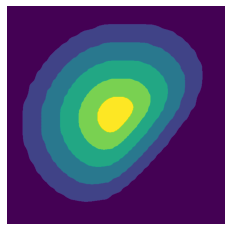

In [92]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0 , 1, cv2.THRESH_BINARY)[1]
mask = thresh.copy()
h, w = thresh.shape[:2]

num_parts = 5
for i in range(num_parts, 0, -1):
    scale = i/5
    new_h, new_w = int(h * scale), int(w * scale)
    d_h, d_w = (h - new_h) // 2, (w - new_w) // 2
    resized = cv2.resize(thresh, (new_w, new_h))
    copy = np.zeros_like(thresh)
    copy[d_h:d_h + new_h, d_w:d_w + new_w] = resized*2
    copy[copy == 0] = 1
    mask *= copy

for i in range(1,num_parts+1):
    mask[mask==2**i]=(255*i/num_parts)
    
plt.axis("off")
plt.imshow(mask)
plt.show()

In [105]:
reshaped_img = mask.reshape(360000,1)
unique_colors = np.unique(reshaped_img, axis=0)
for color in unique_colors:
    print(color)

[0]
[51]
[102]
[153]
[204]
[255]


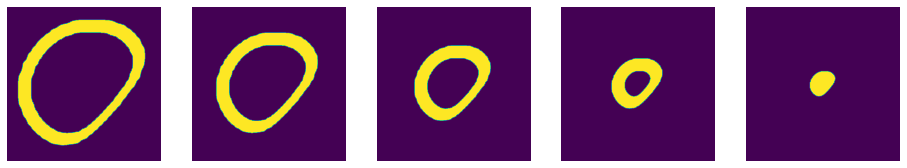

In [93]:
color_coordinates = {}

plt.figure(figsize=(16,16))
for i in range(1,num_parts+1):
    color = int(255*i/num_parts)
    mask_part = cv2.inRange(mask, np.array(color, dtype=np.uint8), np.array(color, dtype=np.uint8))
    plt.subplot(1,num_parts,i)
    plt.axis("off")
    plt.imshow(mask_part)
#     indices = np.where(mask != 0)
#     coordinates = np.column_stack((indices[1], indices[0]))
#     color_coordinates[color] = coordinates

# for color, coordinates in color_coordinates.items():
#     print(f'Color {color}: {coordinates.shape}')

0.2716293923118686


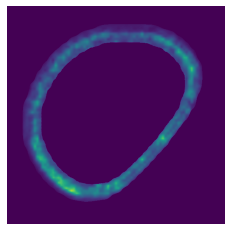

0.20998621976377624


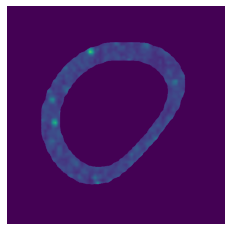

0.20699993724534604


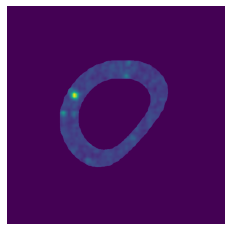

0.20529751122750034


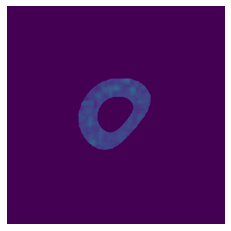

0.2105737289703426


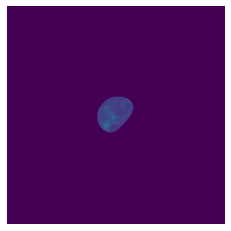

In [97]:
part_intensity=[]
vmin,vmax=0,1
for i in range(1,num_parts+1):
    color = int(255*i/num_parts)
    mask_part = cv2.inRange(mask, np.array(color, dtype=np.uint8), np.array(color, dtype=np.uint8))/255
    cam_mask = cam_pad*mask_part*thresh
    
    non_zero_values = cam_mask[np.nonzero(cam_mask)]
    average = np.mean(non_zero_values)
    part_intensity.append(average)
    
    print(average)
    plt.axis("off")
    plt.imshow(cam_mask, vmin=vmin, vmax=vmax)
    plt.show()

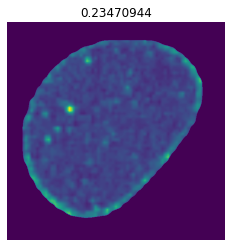

In [114]:
intensity=[]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0 , 1, cv2.THRESH_BINARY)[1]
cam_mask = cam_img*thresh

non_zero_values = cam_mask[np.nonzero(cam_mask)]
average = np.mean(non_zero_values)
intensity.append(average)

plt.title(average)
plt.axis("off")
plt.imshow(cam_mask, vmin=vmin, vmax=vmax)

In [140]:
import pandas as pd

In [196]:
cam = "ScoreCAM"
chip_li = ["All", "H3K27ac", "CTCF", "Hoechst"]
chip = chip_li[3]

name = cam+"_"+chip+"_intensity"
ctrl_name = cam+"_Ctrl_"+chip+"_intensity"
vpa_name = cam+"_VPA_"+chip+"_intensity"
intensity_CAM_Ctrl_CHIP = np.load("./Datasets/"+ctrl_name+".npy",allow_pickle=True)
intensity_CAM_VPA_CHIP  = np.load("./Datasets/"+vpa_name+".npy",allow_pickle=True)
print(ctrl_name,intensity_CAM_Ctrl_CHIP.shape)
print(vpa_name,intensity_CAM_VPA_CHIP.shape)

ScoreCAM_Ctrl_Hoechst_intensity (2904,)
ScoreCAM_VPA_Hoechst_intensity (2951,)


In [197]:
df = pd.DataFrame({'Ctrl': intensity_CAM_Ctrl_CHIP[:2900], 'VPA': intensity_CAM_VPA_CHIP[:2900]})
df.index = np.arange(1, len(df) + 1)
df.to_csv(name+".csv", index=True, index_label="num")
print(df)

          Ctrl       VPA
1     0.359783  0.268463
2     0.265458  0.234768
3     0.285774  0.283785
4     0.320850  0.229324
5     0.275151  0.188346
...        ...       ...
2896  0.304099  0.265503
2897  0.325859  0.204237
2898  0.303287  0.286292
2899  0.303147  0.245236
2900  0.274922  0.268379

[2900 rows x 2 columns]


In [198]:
name = cam+"_"+chip+"_allpartintensity"
ctrl_name = cam+"_Ctrl_"+chip+"_allpartintensity"
vpa_name = cam+"_VPA_"+chip+"_allpartintensity"
allpartintensity_CAM_Ctrl_CHIP = np.load("./Datasets/"+ctrl_name+".npy",allow_pickle=True)
allpartintensity_CAM_VPA_CHIP  = np.load("./Datasets/"+vpa_name+".npy",allow_pickle=True)
print(ctrl_name,allpartintensity_CAM_Ctrl_CHIP.shape)
print(vpa_name,allpartintensity_CAM_VPA_CHIP.shape)
print(ctrl_name,allpartintensity_CAM_Ctrl_CHIP)
print(vpa_name,allpartintensity_CAM_VPA_CHIP)

ScoreCAM_Ctrl_Hoechst_allpartintensity (2904, 5)
ScoreCAM_VPA_Hoechst_allpartintensity (2951, 5)
ScoreCAM_Ctrl_Hoechst_allpartintensity [[0.47389219 0.30316622 0.30778338 0.27873132 0.25167065]
 [0.33627328 0.2141875  0.22642252 0.24561691 0.2517719 ]
 [0.38249754 0.23305907 0.21521312 0.25300032 0.24569424]
 ...
 [0.38133824 0.23927766 0.23652193 0.25130731 0.25955967]
 [0.38719474 0.30180924 0.31206432 0.30529605 0.32445405]
 [0.37902186 0.28461877 0.26929706 0.25766778 0.25820116]]
ScoreCAM_VPA_Hoechst_allpartintensity [[0.34881196 0.22723437 0.22872094 0.21533877 0.20351533]
 [0.32221839 0.18367371 0.18094328 0.19968338 0.1915024 ]
 [0.35698112 0.24018689 0.26279649 0.22873738 0.21437706]
 ...
 [0.31194592 0.19012327 0.19273813 0.20130306 0.22661285]
 [0.37220437 0.21001394 0.20124563 0.19800482 0.21266851]
 [0.40023096 0.21179152 0.22500609 0.22573136 0.21287679]]


In [199]:
ctrl_distribute=[]
for i in range(allpartintensity_CAM_Ctrl_CHIP.shape[0]):
    ctrl_distribute.append(allpartintensity_CAM_Ctrl_CHIP[i][0]/sum(allpartintensity_CAM_Ctrl_CHIP[i]))
print(len(ctrl_distribute))

2904


In [200]:
vpa_distribute=[]
for i in range(allpartintensity_CAM_VPA_CHIP.shape[0]):
    vpa_distribute.append(allpartintensity_CAM_VPA_CHIP[i][0]/sum(allpartintensity_CAM_VPA_CHIP[i]))
print(len(vpa_distribute))

2951


In [201]:
df = pd.DataFrame({'Ctrl': ctrl_distribute[:2900], 'VPA': vpa_distribute[:2900]})
df.index = np.arange(1, len(df) + 1)
df.to_csv(name+".csv", index=True, index_label="num")
print(df)

          Ctrl       VPA
1     0.293387  0.285065
2     0.263894  0.298898
3     0.287708  0.273952
4     0.265701  0.281697
5     0.287140  0.284029
...        ...       ...
2896  0.286168  0.282829
2897  0.271283  0.306205
2898  0.261114  0.317342
2899  0.269163  0.270645
2900  0.328656  0.261854

[2900 rows x 2 columns]
